# Überprüfung der Objektdefinition

Die von Hartwig vorgeschlagene Objektdefinition scheint oft gut zu funktioniereren, aber bei manchen Fällen treten ein paar Probleme auf:

1. Es gibt Sprünge bei der Objektgröße: das Objekt wird von einem zum anderen Zeitschritt kleiner, weil die Objektdefinition auf einer anderen Kurve basiert.

2. Bei Situationen mit vielen eng benachbarten Wolken, ändert sich das Objekt zwischen Zeitschritten manchmal stark, weil benachbarte Wolken manchmal zu einem Objekt zusammen gefasst werden und dann wieder nicht.

Deshalb wäre es gut zu wissen, wann und weshalb die Probleme auftreten. Darüber hinaus sollte untersucht werden, wie empfindlich die Objektdefinition auf Parameteränderungen reagiert.

In [3]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Codezellen an- oder ausschalten.</button>''', raw=True)

Codezellen an- oder ausschalten.

In [121]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from standard_config import *
import sys

sys.path.append("{}/utils/io".format(local_home_path))
import file_io as fio
import io_config as ioc

sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
import segmentation as oseg

import glob
from ipywidgets import *

import seaborn as sns
sns.set_context("talk")

In [122]:
haci_cases = glob.glob("{}/*.nc".format(ioc.haci_track_data_path))

In [123]:
example_case = fio.read_nc_file(haci_cases[100])

In [124]:
def plot_haci_case(case_data):
    from plotting_tools.colormaps import enhanced_colormap2
    emap = enhanced_colormap2()
    
    from plotting_tools.colormaps import radar_cmap as rc
    
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].pcolormesh(case_data['slon'],case_data['slat'],ir,vmin=210,vmax=300,cmap=emap)
        p1 = axs[i].contourf(case_data['rlon'],
                             case_data['rlat'],
                             np.ma.masked_greater(np.ma.masked_less(case_data['rx'][i],5),70),
                             np.arange(5,75,5),
                             vmin=5,vmax=70,cmap=rc(),
                             alpha=0.5)
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                       unit='m',
                                                                       timezone='UTC'),
                                         (i*5) - 30))

    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'RX / dBZ')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm) / K')
    
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig 

def plot_case_object(case_data,object_data):
        
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].imshow(ir,vmin=210,vmax=300,cmap='gray_r')
        axs[i].imshow(np.ma.masked_less(object_data[i],1),alpha=0.5)
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                       unit='m',
                                                                       timezone='UTC'),
                                         (i*5) - 30))

        
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig    

## 1. Die Objektdefinition

Ein Objekt wird folgendermaßen über einen adaptiven Schwellwert definiert:

$$ T_\mathrm{Schwellwert} = \mathrm{max}\left( T_\mathrm{Minimum} + \sigma; T_\mathrm{Minimum} + \sigma + k \cdot \frac{T_\mathrm{Minimum} - T_\mathrm{Max.}}{T_\mathrm{Min.} - T_\mathrm{Max.}}; T_\mathrm{fest}\right)$$

Das Kernstück ist die Temperatur eines lokalen Minimums $T_\mathrm{Minimum}$, das eine bestimmte Tiefe $d$ gegenüber seiner Umgebung haben muss. 

Als Ausgangspunkt werden folgende Werte gewählt:
* minimale Tiefe eines lokalen Minimums: $d = 5\,\mathrm{K}$
* Differenz vom Wert des lokalen Minimums bis zur Objektgrenze: $\sigma = 5\,\mathrm{K}$
* Faktor für den Term, der die Auffächerung bestimmt: $k = 15$
* Maximaltemperatur für die Berechnung der Auffächerung der adaptiven Schwellwertbestimmung: $T_\mathrm{Max.} = 273,15\,\mathrm{K}$
* Minimaltemperatur für die Berechnung der Auffächerung der adaptiven Schwellwertbestimmung: $T_\mathrm{Min.} = 220\,\mathrm{K}$
* fester Schwellwert, für sehr kalte lokale Minima: $T_\mathrm{fest} = 240\,\mathrm{K}$

## 2. Empfindlichkeitsuntersuchung der Objektdefinition

Als nächstes spielen wir eine Reihe von Werten durch, um zu sehen, wie empfindlich die Objektdefinition auf eine Änderung der Werte reagiert.

In [125]:
spreads = np.arange(0,25,5)
Tmax = np.arange(240,300,5)
Tmin = np.arange(180,230,5)
Tfix = np.arange(220,270,5)

In [126]:
def adaptive_object_threshold(Tminimum,spread=5,Tmax=273.15,Tmin=220,Tfix=240):
    return np.max((Tminimum + spread, Tminimum + spread + 15 * ((Tminimum - Tmax)/(Tmin-Tmax)),Tfix))

In [127]:
Tthresh = [adaptive_object_threshold(T) for T in np.arange(300,199,-1)]

## 2.1 Adaptive Objektdefinition mit aktuellen Werten

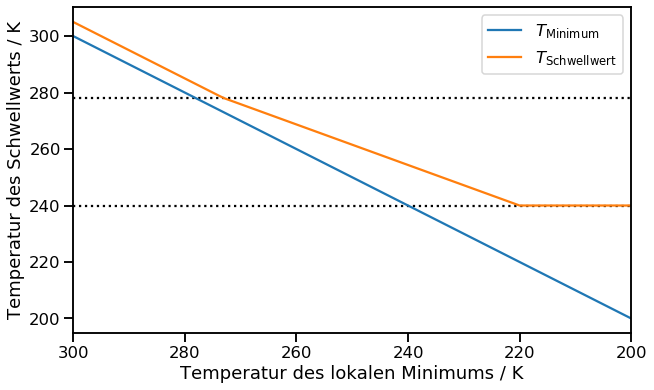

In [128]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.axhline(240,linestyle='dotted',color='black')
ax.axhline(278.15,linestyle='dotted',color='black')
ax.plot(np.arange(300,199,-1),np.arange(300,199,-1),label=r"$T_\mathrm{Minimum}$")
ax.plot(np.arange(300,199,-1),Tthresh,label=r"$T_\mathrm{Schwellwert}$")
ax.set_xlim(300,200)
ax.legend()
ax.set_xlabel("Temperatur des lokalen Minimums / K")
ax.set_ylabel("Temperatur des Schwellwerts / K");

In [162]:
T_fixed_spread = [T+5 for T in np.arange(300,273.15,-.15)]

In [167]:
T_dynamic_spread = [T + 5 + 15*(T - 273.15)/ (220 - 273.15) for T in np.arange(273.15,220,-.15)]

In [170]:
T_fixed = [240 for T in np.arange(220,199,-.15)]

Wie man sieht, ist die Objektdefinition eine zusammengesetzte Funktion. Der Objektschwellwert wird über einem Wert von $T_\mathrm{Minimum} + \sigma$ konstant auf diesem Verhältnis gehalten. Darunter wird er mit abnehmender $T_\mathrm{Minimum}$ immer weiter aufgefächert, bis er den festen Schwellwert $T_\mathrm{fest}$ erreicht.


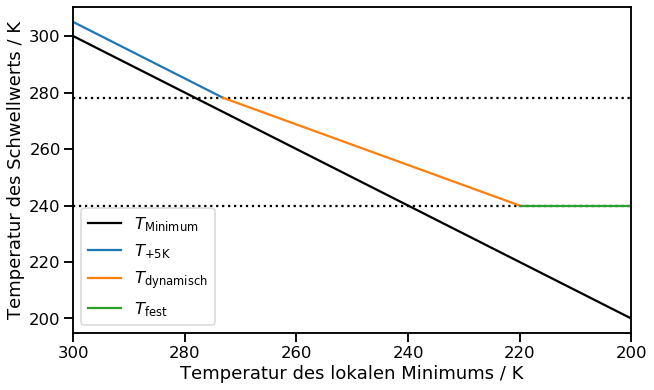

In [182]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.axhline(240,linestyle='dotted',color='black')
ax.axhline(278.15,linestyle='dotted',color='black')
ax.plot(np.arange(300,199,-1),np.arange(300,199,-1),label=r"$T_\mathrm{Minimum}$",color='k')
ax.plot(np.arange(300,273.15,-.15),T_fixed_spread,label=r"$T_\mathrm{+ 5 K}$")
ax.plot(np.arange(273.15,220,-.15),T_dynamic_spread,label=r"$T_\mathrm{dynamisch}$")
ax.plot(np.arange(220,199,-.15),T_fixed,label=r"$T_\mathrm{fest}$")
ax.set_xlim(300,200)
ax.legend()
ax.set_xlabel("Temperatur des lokalen Minimums / K")
ax.set_ylabel("Temperatur des Schwellwerts / K");

Als erstes sehen wir uns den Auffächerungsterm näher an.

### 2.1.1 Auffächerungsterm

Der Auffächerungsterm sieht wie folgt aus:

$$ k \cdot \frac{T_\mathrm{Minimum} - T_\mathrm{Max.}}{T_\mathrm{Min.} - T_\mathrm{Max.}}$$

und ist von einer Reihe von Faktoren abhängig. Zunächst ist da der erste Skalierungsfaktor $k$ und eine weitere Skalierung in Abhängigkeit $T_\mathrm{Max.}$ und $T_\mathrm{Min.}$. Zuerst sehen wir uns an, wie sich $k$ verhält.

In [174]:
Trange = np.arange(273.15,180,-0.15)

In [175]:
krange = np.arange(5,35,5)

In [176]:
adaptive_spread = dict()

for k in krange:
    ts = []
    for T in Trange:
        ts.append(T + 5 + k * ((T - 273.15)/(220-273.15)))
    adaptive_spread[k] = ts

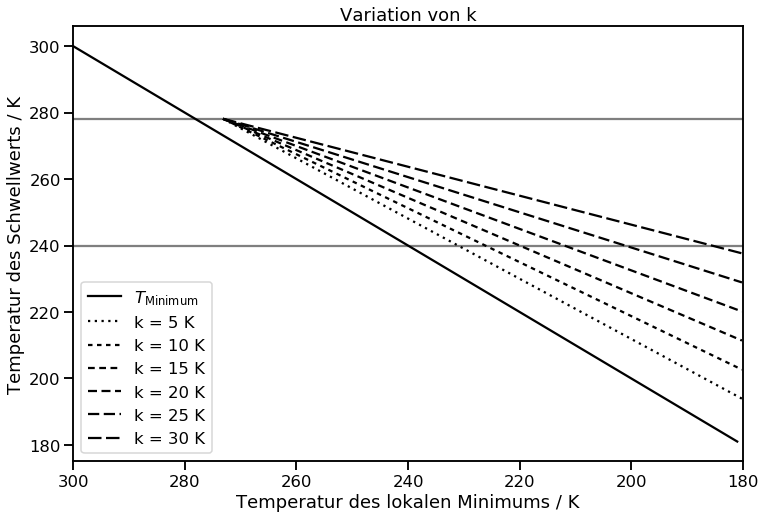

In [183]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(np.arange(300,180,-1),np.arange(300,180,-1),color='black',label=r'$T_\mathrm{Minimum}$')

for i,k in enumerate(krange):
    ax.plot(Trange,adaptive_spread[k],color='black',linestyle=(0,(i+1,2)),label="k = {} K".format(k))
    
ax.set_xlim(300,180)
ax.axhline(278.15,linestyle='solid',color='black',alpha=0.5)
ax.axhline(240,linestyle='solid',color='black',alpha=0.5)
ax.legend()
ax.set_title("Variation von k")
ax.set_xlabel("Temperatur des lokalen Minimums / K")
ax.set_ylabel("Temperatur des Schwellwerts / K");

Der Faktor vor dem Skalierungsterm der Auffächerung sorgt dafür, dass die Auffächerung breiter oder schmaler ist. Er hat somit einen Einfluss auf die sich ergebende Objektfläche. Außerdem hat er einen Einfluss darauf, wann auf den festen Schwellwert übergegangen wird. Mit einem Wert von <i>k</i>&thinsp;=&thinsp;15 ist der adaptiv berechnete Schwellwert genau dann dem festen Schwellwert, wenn <i>T</i><sub>Minimum</sub> erreicht wird. Um diesen Zusammenhang zuwahren, muss <i>k</i> in Abhängigkeit von <i>T</i><sub>Minimum</sub>, <i>T</i><sub>fest</sub> und &sigma; gewählt werden: <i>k</i>=<i>T</i><sub>fest</sub> - <i>T</i><sub>Minimum</sub> - &sigma;.

Die Formel für die Objektdefinition sieht dann wie folgt aus:

$$ T_\mathrm{Schwellwert} = \mathrm{max}\left( T_\mathrm{Minimum} + \sigma; T_\mathrm{Minimum} + \sigma + \left( T_\mathrm{fest} - T_\mathrm{Minimum} - \sigma \right) \cdot \frac{T_\mathrm{Minimum} - T_\mathrm{Max.}}{T_\mathrm{Min.} - T_\mathrm{Max.}}; T_\mathrm{fest}\right)$$

Diese Definition könnte auch schon vielleicht auch schon ausreichen Sprünge der Objektflächen zu verringern.

Als nächstes sehen wir uns den Einfluss von $T_\mathrm{Max.}$ und $T_\mathrm{Min.}$ an.

### 2.1.2 Maximal- und Minimaltemperatur des Auffächerungsterms

In [178]:
s = 5
Tf = 240
Tmin = 220
Tmax = 273.15

In [205]:
adaptive_spread_Tmax = dict()

for Tm in np.arange(300,265,-5):
    ts = []
    for T in np.arange(Tmax,Tmin,-1):
        k = Tf - Tmin - s
        ts.append(T + s + k * ((T - Tm)/(Tmin-Tm)))
    adaptive_spread_Tmax[Tm] = ts

In [199]:
tmax_label = r"$T_\mathrm{Max.}$"

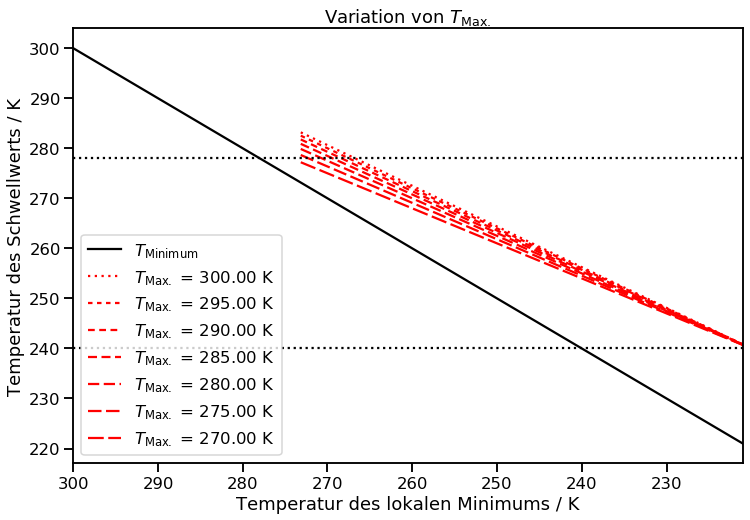

In [206]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(np.arange(300,220,-1),np.arange(300,220,-1),color='black',label=r'$T_\mathrm{Minimum}$')

for i,Tm in enumerate(np.arange(300,265,-5)):
    ax.plot(np.arange(Tmax,Tmin,-1),adaptive_spread_Tmax[Tm],color='red',linestyle=(0,(i+1,2)),
            label=r"{} = {:.2f} K".format(tmax_label,Tm))
    
ax.set_xlim(300,221)
ax.axhline(Tmax+s,linestyle='dotted',color='black')
ax.axhline(Tf,linestyle='dotted',color='black')
ax.legend()
ax.set_title(r"Variation von $T_\mathrm{Max.}$")
ax.set_xlabel("Temperatur des lokalen Minimums / K")
ax.set_ylabel("Temperatur des Schwellwerts / K");

Der Wert von $T_\mathrm{Max.}$ beinflusst ebenfalls die Stärke der Auffächerung, aber vor allem im höheren Temperaturbereich. Je kleiner $T_\mathrm{Max.}$ ist, desto stärker ist die Auffächerung. Wenn man $T_\mathrm{Max.}$ allerdings sehr groß macht, werden auch die Objekte sehr groß und es werden eventuell auch unbewölkte Bereiche mit eingeschlossen.

In [207]:
adaptive_spread_Tmin = dict()

for Tm in np.arange(240,180,-10):
    ts = []
    for T in np.arange(Tmax,220,-1):
        k = Tf - Tm - s
        ts.append(T + 5 + k * ((T - 273.15)/(Tm-273.15)))
    adaptive_spread_Tmin[Tm] = ts

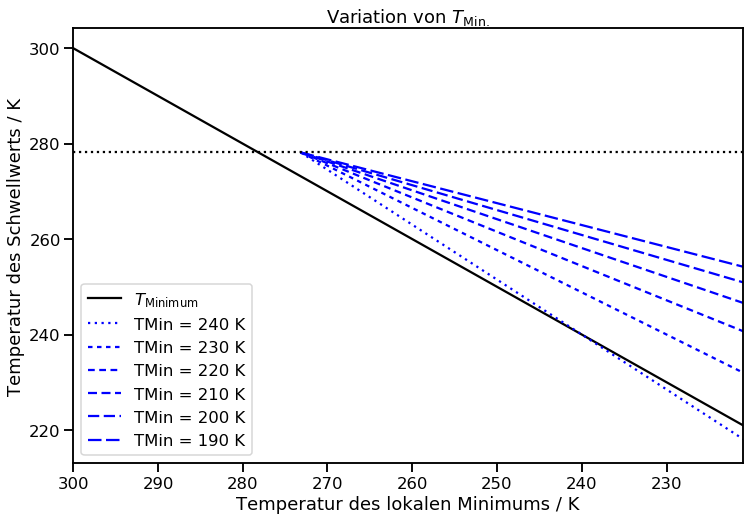

In [208]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(np.arange(300,220,-1),np.arange(300,220,-1),color='black',label=r'$T_\mathrm{Minimum}$')

for i,Tm in enumerate(np.arange(240,180,-10)):
    ax.plot(np.arange(Tmax,220,-1),adaptive_spread_Tmin[Tm],color='blue',linestyle=(0,(i+1,2)),label="TMin = {} K".format(Tm))
    
ax.set_xlim(300,221)
ax.axhline(278.15,linestyle='dotted',color='black')
ax.legend()
ax.set_title(r"Variation von $T_\mathrm{Min.}$")
ax.set_xlabel("Temperatur des lokalen Minimums / K")
ax.set_ylabel("Temperatur des Schwellwerts / K");

Der Wert von $T_\mathrm{Max.}$ beinflusst ebenfalls die Stärke der Auffächerung, aber vor allem im niedrigeren Temperaturbereich. Je kleiner $T_\mathrm{Min.}$ ist, desto schwächer ist die Auffächerung. $T_\mathrm{Max.}$ und $T_\mathrm{Min.}$ verlaufen also entgegengesetzt.

Als nächstes sehen wir uns den Aufächerungsterm zusammen an.

In [257]:
adaptive_spread = {Tmn:{Tmx:[] for Tmx in np.arange(290,260,-10)} for Tmn in np.arange(220,190,-10)}

for Tmn in np.arange(220,190,-10):
    for Tmx in np.arange(290,260,-10):
        ts = []
        for T in np.arange(Tmax+20,190,-1):
            k = Tf - Tmn - s
            ts.append(T + s + k * ((T - Tmx)/(Tmn-Tmx)))
            
        adaptive_spread[Tmn][Tmx] = ts

In [246]:
line_colour = {290:'red',280:'blue',270:'green'}
line_style = {220:'dashed',210:'dashdot',200:'dotted'}

Text(0.5, 0, 'Temperatur des Schwellwerts / K')

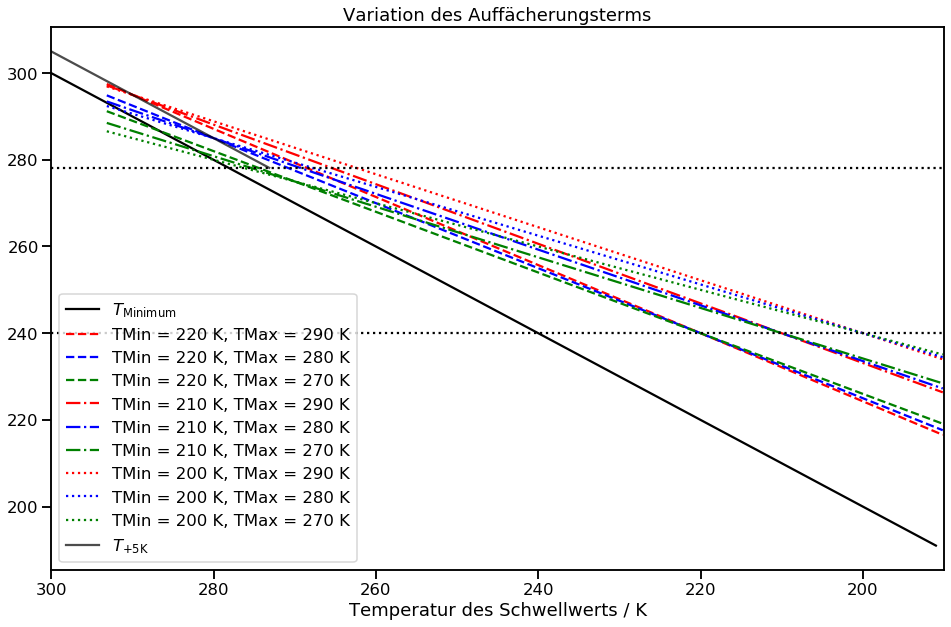

In [264]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.plot(np.arange(300,190,-1),np.arange(300,190,-1),color='black',label=r'$T_\mathrm{Minimum}$')

k = 0
for i,Tmn in enumerate(np.arange(220,190,-10)):
    for j,Tmx in enumerate(np.arange(290,260,-10)):
        ax.plot(np.arange(Tmax+20,Tmin-30,-1),
                adaptive_spread[Tmn][Tmx],
                color=line_colour[Tmx],
                linestyle=line_style[Tmn],label="TMin = {} K, TMax = {} K".format(Tmn,Tmx))
        k += 1
        
ax.plot(np.arange(300,273.15,-.15),T_fixed_spread,color='k',alpha=0.7,label=r"$T_\mathrm{+ 5 K}$")
ax.set_xlim(300,190)
ax.axhline(Tmax+s,linestyle='dotted',color='black')
ax.axhline(Tf,linestyle='dotted',color='black')
ax.legend()
ax.set_title(r"Variation des Auffächerungsterms")
ax.set_xlabel("Temperatur des lokalen Minimums / K")
ax.set_xlabel("Temperatur des Schwellwerts / K")

In [266]:
def adaptive_object_threshold2(Tminimum,spread=5,Tmax=273.15,Tmin=220,Tfix=240):
    k = Tfix - Tmin - spread
    return np.max((Tminimum + spread, Tminimum + spread + k * ((Tminimum - Tmax)/(Tmin-Tmax)),Tfix))

In [273]:
adaptive_threshold = {Tmn:{Tmx:[] for Tmx in np.arange(290,260,-10)} for Tmn in np.arange(220,190,-10)}

for Tmn in np.arange(220,190,-10):
    for Tmx in np.arange(290,260,-10):
        ts = []
        for T in np.arange(300,190,-1):
            ts.append(adaptive_object_threshold2(T,5,Tmx,Tmn,240))
            
        adaptive_threshold[Tmn][Tmx] = ts

In [278]:
tmax_label = r"$T_\mathrm{Max.}$"
tmin_label = r"$T_\mathrm{Min.}$"

Text(0.5, 0, 'Temperatur des Schwellwerts / K')

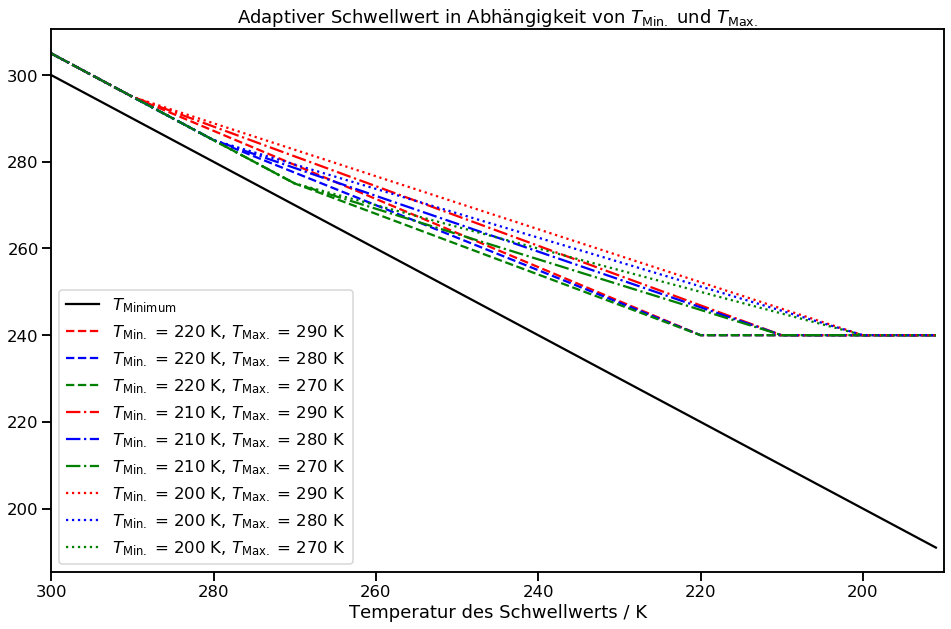

In [279]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.plot(np.arange(300,190,-1),np.arange(300,190,-1),color='black',label=r'$T_\mathrm{Minimum}$')

k = 0
for i,Tmn in enumerate(np.arange(220,190,-10)):
    for j,Tmx in enumerate(np.arange(290,260,-10)):
        ax.plot(np.arange(300,190,-1),
                adaptive_threshold[Tmn][Tmx],
                color=line_colour[Tmx],
                linestyle=line_style[Tmn],label="{} = {} K, {} = {} K".format(tmin_label,Tmn,tmax_label,Tmx))
        k += 1

ax.set_xlim(300,190)
ax.legend()
ax.set_title(r"Adaptiver Schwellwert in Abhängigkeit von $T_\mathrm{Min.}$ und $T_\mathrm{Max.}$")
ax.set_xlabel("Temperatur des lokalen Minimums / K")
ax.set_xlabel("Temperatur des Schwellwerts / K")

Mit einer Zunahme $T_\mathrm{Max.}$ beginnt die Aufweitung bereits bei höheren Temperaturen des lokalen Minimums. Es werden also bereits bei wärmeren Wolken größere Teilbereiche als Objekt definiert und die Objekte werden damit größer als bei gleichen Temperaturen des lokalen Minimums und niedrigeren $T_\mathrm{Max.}$-Werte. Mit einer Abnahme von $T_\mathrm{Min.}$ wird erst bei niedrigeren Temperaturen des lokalen Minimums auf den festen Schwellwert übergegangen. Das heißt, dass die Objekte im Vergleich zu höheren Temperaturen lokalen Minimums größer werden und der feste Schwellwert oftmals nie erreicht wird, weil die Wolken nicht so kalt werden können.